## Kütüphaneler

In [ ]:
import tensorflow as tf

import numpy as np

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt

tf.__version__

'2.11.0'

## Yapay Veri Oluşturma

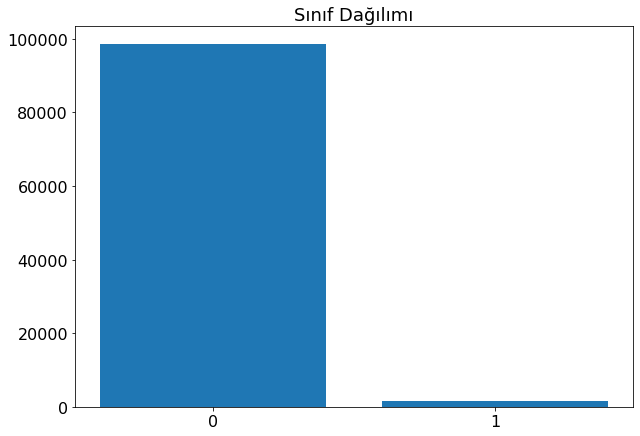

In [ ]:
X, y = make_classification(n_samples=100000,
                           n_features=10,
                           n_classes=2,
                           weights=[0.99, 0.01],
                           n_redundant=0)

unique, counts = np.unique(y, return_counts=True)

plt.figure(figsize = (10, 7))
plt.bar(unique, counts)

plt.xticks(unique, fontsize = 16)
plt.yticks(fontsize = 16)
plt.title("Sınıf Dağılımı", fontsize = 18)

plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.8, 
                                                    stratify=y,
                                                    random_state=42)

In [ ]:
class_weights = compute_class_weight(class_weight="balanced",
                                     classes=np.unique(y_train),
                                     y=y_train)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.5075755653122859, 1: 33.50083752093802}

## Modeller

In [ ]:
input_layer = tf.keras.Input(shape = (10, ))

x = tf.keras.layers.Dense(64)(input_layer)
x = tf.nn.relu(x)

x = tf.keras.layers.Dense(32)(x)
x = tf.nn.relu(x)

x = tf.keras.layers.Dropout(0.3)(x)

x = tf.keras.layers.Dense(1)(x)
x = tf.keras.layers.Activation("sigmoid")(x)

baseline_model = tf.keras.Model(input_layer, x)
baseline_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense (Dense)               (None, 64)                704       
                                                                 
 tf.nn.relu (TFOpLambda)     (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 tf.nn.relu_1 (TFOpLambda)   (None, 32)                0         
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33    

In [ ]:
baseline_model.save_weights("initial_weights.h5")

In [ ]:
class_weight_model = tf.keras.models.clone_model(baseline_model)
focal_loss_model = tf.keras.models.clone_model(baseline_model)
cat_focal_model = tf.keras.models.clone_model(baseline_model)

In [ ]:
baseline_model.compile(optimizer = "adam",
                       loss = "binary_crossentropy",
                       metrics = [tf.keras.metrics.Precision(),
                                  tf.keras.metrics.Recall()])

In [ ]:
history = baseline_model.fit(X_train, y_train,
                   epochs=16,
                   batch_size=128,
                   validation_split=0.2)

Epoch 1/16
500/500 [==============================] - 5s 4ms/step - loss: 0.0970 - precision_1: 0.0659 - recall_1: 0.0708 - val_loss: 0.0536 - val_precision_1: 0.9804 - val_recall_1: 0.2008
Epoch 2/16
500/500 [==============================] - 2s 4ms/step - loss: 0.0489 - precision_1: 0.9804 - recall_1: 0.4228 - val_loss: 0.0475 - val_precision_1: 0.9685 - val_recall_1: 0.4940
Epoch 3/16
500/500 [==============================] - 2s 3ms/step - loss: 0.0452 - precision_1: 0.9544 - recall_1: 0.5307 - val_loss: 0.0455 - val_precision_1: 0.9466 - val_recall_1: 0.4980
Epoch 4/16
500/500 [==============================] - 2s 3ms/step - loss: 0.0433 - precision_1: 0.9490 - recall_1: 0.5507 - val_loss: 0.0449 - val_precision_1: 0.9407 - val_recall_1: 0.5100
Epoch 5/16
500/500 [==============================] - 2s 3ms/step - loss: 0.0430 - precision_1: 0.9482 - recall_1: 0.5423 - val_loss: 0.0446 - val_precision_1: 0.9209 - val_recall_1: 0.5141
Epoch 6/16
500/500 [==============================

In [ ]:
baseline_model.evaluate(X_test, y_test)

625/625 [==============================] - 3s 4ms/step - loss: 0.0390 - precision_1: 0.9043 - recall_1: 0.5686


[0.03901128098368645, 0.9042553305625916, 0.568561851978302]

In [ ]:
predictions = baseline_model.predict(X_test)

In [ ]:
threshold = 0.1
predictions_binary = np.where(predictions > threshold, 1, 0)
print(classification_report(y_test, predictions_binary, digits=4))
print(confusion_matrix(y_test, predictions_binary))

              precision    recall  f1-score   support

           0     0.9940    0.9969    0.9954     19701
           1     0.7469    0.6020    0.6667       299

    accuracy                         0.9910     20000
   macro avg     0.8704    0.7995    0.8311     20000
weighted avg     0.9903    0.9910    0.9905     20000

[[19640    61]
 [  119   180]]


In [ ]:
threshold = 0.5
predictions_binary = np.where(predictions > threshold, 1, 0)
print(classification_report(y_test, predictions_binary, digits=4))
print(confusion_matrix(y_test, predictions_binary))

              precision    recall  f1-score   support

           0     0.9935    0.9991    0.9963     19701
           1     0.9043    0.5686    0.6982       299

    accuracy                         0.9927     20000
   macro avg     0.9489    0.7838    0.8472     20000
weighted avg     0.9922    0.9927    0.9918     20000

[[19683    18]
 [  129   170]]


## 2.Model

In [ ]:
class_weight_model.load_weights("/content/initial_weights.h5")

In [ ]:
class_weight_model.compile(optimizer = "adam",
                       loss = "binary_crossentropy",
                       metrics = [tf.keras.metrics.Precision(),
                                  tf.keras.metrics.Recall()])
history_cw = class_weight_model.fit(X_train, y_train,
                   epochs=16,
                   batch_size=128,
                   validation_split=0.2,
                   class_weight={0: 0.5076786394212464, 1: 35.05785123966942}
)

Epoch 1/16
500/500 [==============================] - 6s 5ms/step - loss: 0.5155 - precision_4: 0.0609 - recall_4: 0.6698 - val_loss: 0.3790 - val_precision_4: 0.1834 - val_recall_4: 0.5850
Epoch 2/16
500/500 [==============================] - 2s 4ms/step - loss: 0.4505 - precision_4: 0.1469 - recall_4: 0.6489 - val_loss: 0.4129 - val_precision_4: 0.1727 - val_recall_4: 0.5889
Epoch 3/16
500/500 [==============================] - 2s 4ms/step - loss: 0.4387 - precision_4: 0.1830 - recall_4: 0.6395 - val_loss: 0.3301 - val_precision_4: 0.2857 - val_recall_4: 0.5771
Epoch 4/16
500/500 [==============================] - 4s 8ms/step - loss: 0.4319 - precision_4: 0.2166 - recall_4: 0.6364 - val_loss: 0.4066 - val_precision_4: 0.2574 - val_recall_4: 0.5850
Epoch 5/16
500/500 [==============================] - 4s 8ms/step - loss: 0.4268 - precision_4: 0.2660 - recall_4: 0.6353 - val_loss: 0.4297 - val_precision_4: 0.1333 - val_recall_4: 0.6206
Epoch 6/16
500/500 [==============================

In [ ]:
predictions = class_weight_model.predict(X_test)

625/625 [==============================] - 3s 5ms/step


In [ ]:
threshold = 0.4
predictions_binary = np.where(predictions > threshold, 1, 0)
print(classification_report(y_test, predictions_binary, digits=4))
print(confusion_matrix(y_test, predictions_binary))

              precision    recall  f1-score   support

           0     0.9945    0.9128    0.9519     19698
           1     0.1053    0.6689    0.1819       302

    accuracy                         0.9092     20000
   macro avg     0.5499    0.7909    0.5669     20000
weighted avg     0.9810    0.9092    0.9403     20000

[[17981  1717]
 [  100   202]]


## Categorical Focal Loss

In [ ]:
y_pred = [[0.1], [0.8]]
y_true = [[0], [0]]

tf.keras.losses.BinaryFocalCrossentropy(reduction="none")(y_true, y_pred)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.0010536, 1.03004  ], dtype=float32)>

In [ ]:
1.03004 / 0.0010536

977.6385725132878

In [ ]:
y_pred = [[0.1], [0.8]]
y_true = [[0], [0]]

tf.keras.losses.BinaryCrossentropy(reduction="none")(y_true, y_pred)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.10536041, 1.6094375 ], dtype=float32)>

In [ ]:
1.6094375 / 0.10536041

15.275543251967225

In [ ]:
y_pred = [[0.1], [0.8]]
y_true = [[0], [0]]

tf.keras.losses.BinaryFocalCrossentropy(alpha=1, gamma = 0.0, reduction="none")(y_true, y_pred)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.10536041, 1.6094375 ], dtype=float32)>

In [ ]:
class CategoricalFocalCE(tf.keras.losses.Loss):
    def __init__(self, alpha=0.25, gamma = 2.0, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha
        self.gamma = gamma

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, dtype = tf.float32)
        y_pred = tf.cast(y_pred, dtype = tf.float32)

        # objective likelihoodu maximize etmek
        # likelihood'un negatifini alarak
        # -likelihood'u minimize
        # toplamaya çevirmek için log-likelihood --> Çarpımlar -> Toplam
        # -log-likelihood
        # negative log-likelihood

        y_pred = tf.clip_by_value(y_pred, 
                                  tf.keras.backend.epsilon(), 
                                  1 - tf.keras.backend.epsilon())

        cce = -y_true * tf.math.log(y_pred)

        # gamma = focusing parameter
        modulating_factor = tf.pow(1 - y_pred, self.gamma)

        # alpha = weighting parameter
        weighting_factor = tf.multiply(self.alpha, modulating_factor)

        # focal loss
        focal_loss = tf.multiply(weighting_factor, cce)

        return focal_loss

In [ ]:
y_pred = [[0.1, 0.9], [0.8, 0.2]]
y_true = [[0, 1], [0, 1]]

In [ ]:
cfce = CategoricalFocalCE(alpha = [0.5, 33.0], 
                          gamma = 2.0)
cfce(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=8.506524>

In [ ]:
input_layer = tf.keras.Input(shape = (10, ))

x = tf.keras.layers.Dense(64)(input_layer)
x = tf.nn.relu(x)

x = tf.keras.layers.Dense(32)(x)
x = tf.nn.relu(x)

x = tf.keras.layers.Dropout(0.3)(x)

x = tf.keras.layers.Dense(2)(x)
x = tf.keras.layers.Activation("softmax")(x)

categorical_focal_model = tf.keras.Model(input_layer, x)
categorical_focal_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_6 (Dense)             (None, 64)                704       
                                                                 
 tf.nn.relu_4 (TFOpLambda)   (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 tf.nn.relu_5 (TFOpLambda)   (None, 32)                0         
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 2)                 66  

In [ ]:
categorical_focal_model.compile(optimizer = "adam",
                       loss = CategoricalFocalCE(alpha = [0.5, 33.0], 
                                                 gamma = 2.0),
                       metrics = [tf.keras.metrics.Precision(class_id=1),
                                  tf.keras.metrics.Recall(class_id=1)])

y_train_ohe = tf.keras.utils.to_categorical(y_train, 2)

history = categorical_focal_model.fit(X_train, y_train_ohe,
                   epochs=64,
                   batch_size=128,
                   validation_split=0.2)

Epoch 1/64
500/500 [==============================] - 3s 4ms/step - loss: 0.0765 - precision_3: 0.0327 - recall_3: 0.6497 - val_loss: 0.0689 - val_precision_3: 0.0478 - val_recall_3: 0.6827
Epoch 2/64
500/500 [==============================] - 2s 3ms/step - loss: 0.0677 - precision_3: 0.0489 - recall_3: 0.6921 - val_loss: 0.0681 - val_precision_3: 0.0629 - val_recall_3: 0.6426
Epoch 3/64
500/500 [==============================] - 2s 3ms/step - loss: 0.0648 - precision_3: 0.0570 - recall_3: 0.6815 - val_loss: 0.0671 - val_precision_3: 0.0795 - val_recall_3: 0.6104
Epoch 4/64
500/500 [==============================] - 2s 3ms/step - loss: 0.0632 - precision_3: 0.0657 - recall_3: 0.6603 - val_loss: 0.0649 - val_precision_3: 0.0775 - val_recall_3: 0.6185
Epoch 5/64
500/500 [==============================] - 2s 3ms/step - loss: 0.0617 - precision_3: 0.0751 - recall_3: 0.6593 - val_loss: 0.0641 - val_precision_3: 0.0954 - val_recall_3: 0.6145
Epoch 6/64
500/500 [==============================

KeyboardInterrupt: ignored

In [ ]:
predictions = categorical_focal_model.predict(X_test)
predictions

625/625 [==============================] - 1s 1ms/step


array([[0.5979302 , 0.4020698 ],
       [0.6397258 , 0.36027423],
       [0.67771566, 0.3222843 ],
       ...,
       [0.73343   , 0.26657   ],
       [0.57642317, 0.42357686],
       [0.6497188 , 0.3502812 ]], dtype=float32)

In [ ]:
prediction_classes = np.argmax(predictions, axis=-1)
print(classification_report(y_test, prediction_classes, digits=4))
print(confusion_matrix(y_test, prediction_classes))

              precision    recall  f1-score   support

           0     0.9936    0.9340    0.9629     19701
           1     0.1222    0.6054    0.2034       299

    accuracy                         0.9291     20000
   macro avg     0.5579    0.7697    0.5831     20000
weighted avg     0.9806    0.9291    0.9515     20000

[[18401  1300]
 [  118   181]]
